In [1]:
require(tidyverse)
require(stringr)
require(rstan)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract




In [2]:
sim_data_ex = read_rds('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200305_2_stage_impute_beta_missing/RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.3_SIM_DATA.rds')
fit_data_ex = read_rds('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200305_2_stage_impute_beta_missing/RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.3_FIT_DATA.rds')
sum_table_ex = read_csv('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis/20200305_2_stage_impute_beta_missing/RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.3.csv')

Parsed with column specification:
cols(
  label = col_character(),
  tp = col_double(),
  fn = col_double(),
  fp = col_double(),
  tn = col_double(),
  avg_mag_error = col_double(),
  num_sign_error = col_double(),
  n_sig = col_double(),
  n_true = col_double(),
  N_SIM = col_double(),
  N_SAMPLE = col_double(),
  FRAC_SIG = col_double(),
  MISSING_RATE = col_double()
)



In [3]:
sum_table_ex

label,tp,fn,fp,tn,avg_mag_error,num_sign_error,n_sig,n_true,N_SIM,N_SAMPLE,FRAC_SIG,MISSING_RATE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bayes,4,7,0,16,0.7254334,0,4,11,1,100,0.4,0.3
raw,10,1,0,16,1.1962874,0,10,11,1,100,0.4,0.3
bon,3,8,0,16,1.5460570,0,3,11,1,100,0.4,0.3
bh,6,5,0,16,1.4057172,0,6,11,1,100,0.4,0.3


In [4]:
names(fit_data_ex)

[1] "sum_table"   "stage_1_fit" "stage_2_fit"

In [27]:
stage_1_fit = fit_data_ex$stage_1_fit
stage_2_fit = fit_data_ex$stage_2_fit

In [10]:
# https://cran.r-project.org/web/packages/rstan/vignettes/stanfit-objects.html

In [28]:
inits = get_inits(stage_2_fit)[[1]]
stage_1_post = extract(stage_1_fit)

In [24]:
names(inits)

[1] "x_impute_raw" "beta_x"       "alpha_x"      "sigma_beta_x" "nu_x"        
[6] "x_impute"

In [30]:
names(stage_1_post)

[1] "beta_impute_raw"     "alpha_impute"        "sigma_impute"       
[4] "sigma_beta_impute_x" "beta_impute"         "x_impute_mean"      
[7] "x_impute"            "lp__"

In [40]:
names(sim_data_ex)

[1] "df_sample"        "truth"            "df_censored"      "df_naive_impute" 
[5] "missing_rates"    "thresholds"       "est.thresholds"   "est.naive_impute"

In [29]:
dim(stage_1_post$x_impute)

[1] 5000 1363

In [55]:
imputation_mean = apply(stage_1_post$x_impute, FUN=mean, MARGIN=2)

In [56]:
imputation_sd = apply(stage_1_post$x_impute, FUN=sd, MARGIN=2)

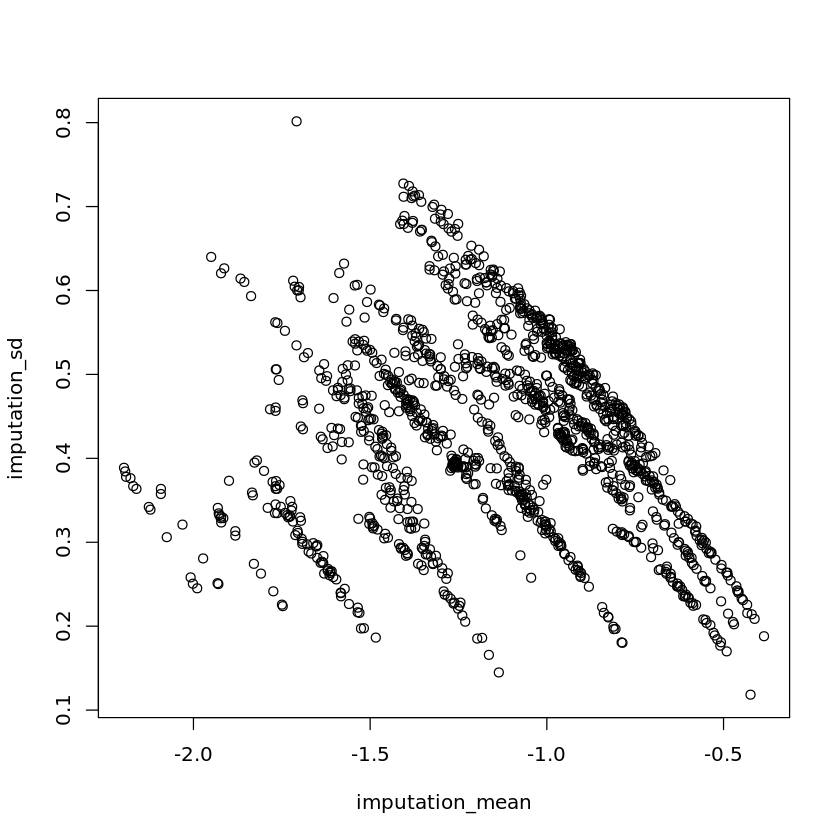

In [57]:
plot(imputation_mean,imputation_sd)

In [93]:
df_censored = sim_data_ex$df_censored
df_sample = sim_data_ex$df_sample
df_naive_impute = sim_data_ex$df_naive_impute
x_censored = df_censored %>% select(-c(died_90_day))

In [59]:
N_miss = sum(is.na(x_censored))
x_censored = as.matrix(x_censored)
x_missing = matrix(nrow = N_miss, ncol = 2)

# make a table were the first column is the row number in x_censored
# second column contains the metabolite column number in x_censored
col1 = c()
col2 = c()
for(j in 1:dim(x_censored)[2]) {
    missing_in_col = which(is.na(x_censored[,j]))
    col1 = c(col1, missing_in_col)
    col2 = c(col2, rep(j,length(missing_in_col)))
}
x_missing[,1] = col1
x_missing[,2] = col2

In [94]:
x_true = df_sample[ x_missing ]
x_naive_impute = df_naive_impute[ x_missing ]

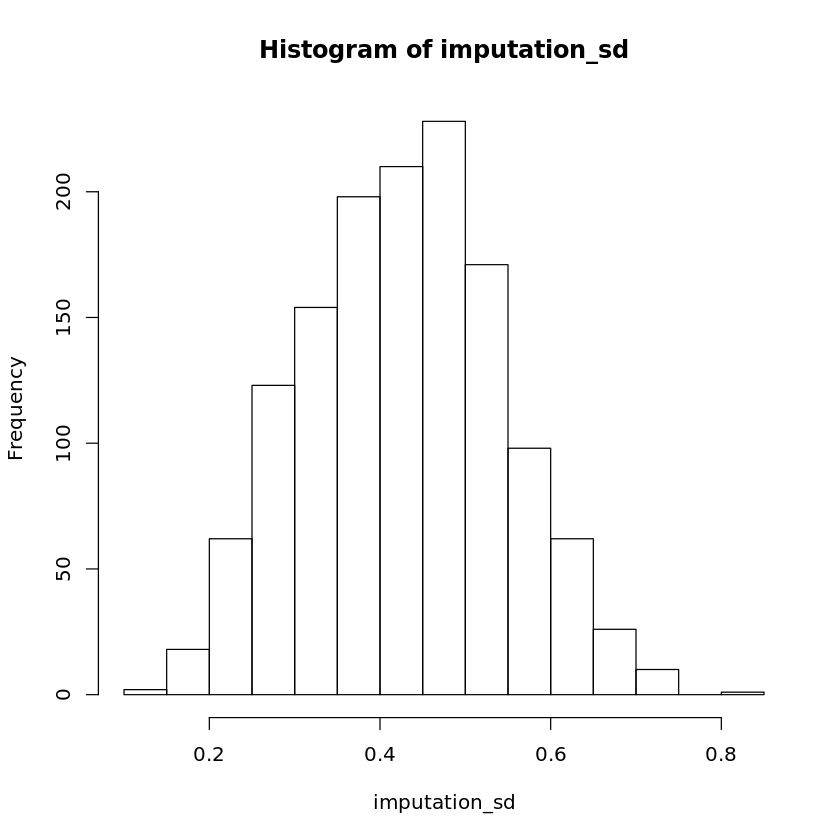

In [65]:
hist(imputation_sd)

In [86]:
weights = 1-imputation_sd/max(imputation_sd)


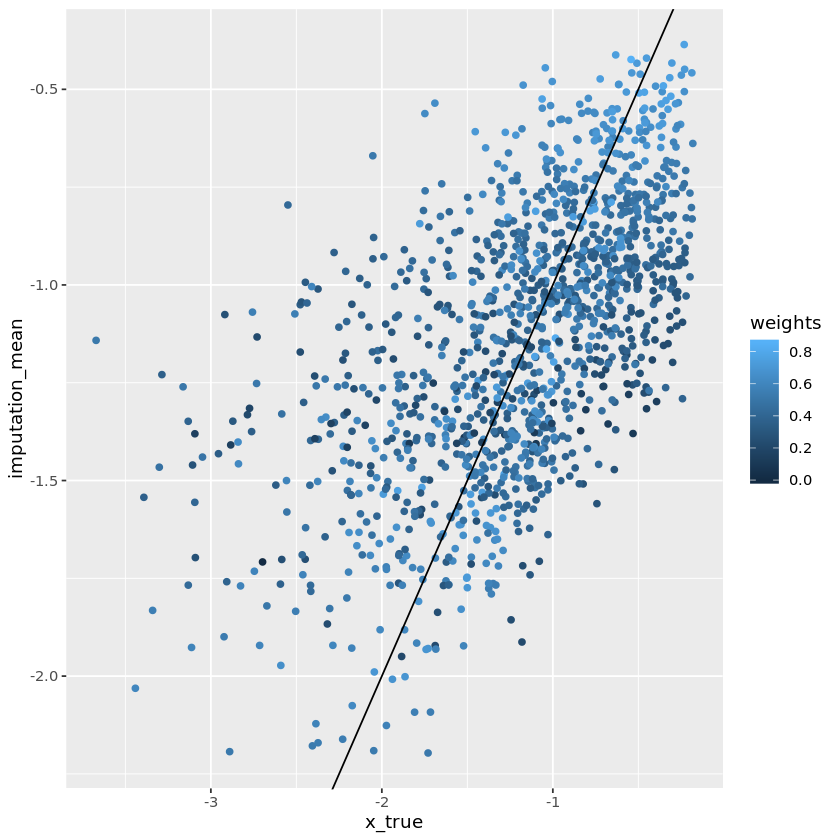

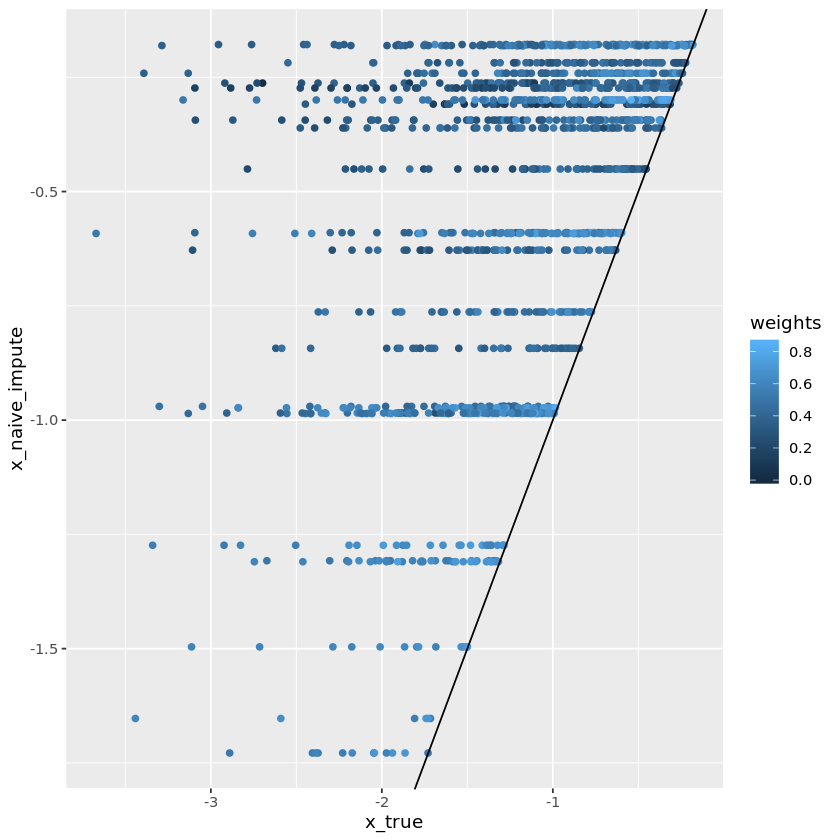

In [95]:
ggplot() + geom_point(aes(x=x_true,y=imputation_mean,color=weights)) + geom_abline(slope=1,intercept=0)

ggplot() + geom_point(aes(x=x_true,y=x_naive_impute,color=weights)) + geom_abline(slope=1,intercept=0)

#
#

In [90]:
summary( lm(x_true ~ imputation_mean, weights = weights) )


Call:
lm(formula = x_true ~ imputation_mean, weights = weights)

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-1.78035 -0.17202  0.06571  0.24246  0.68870 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.03952    0.04019   0.983    0.326    
imputation_mean  1.07931    0.03428  31.487   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3168 on 1360 degrees of freedom
Multiple R-squared:  0.4216,	Adjusted R-squared:  0.4212 
F-statistic: 991.4 on 1 and 1360 DF,  p-value: < 2.2e-16


In [91]:
summary(lm(x_true ~ imputation_mean))


Call:
lm(formula = x_true ~ imputation_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.48634 -0.26220  0.08764  0.34100  1.10668 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.06619    0.04626   1.431    0.153    
imputation_mean  1.09586    0.03902  28.083   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4936 on 1361 degrees of freedom
Multiple R-squared:  0.3669,	Adjusted R-squared:  0.3664 
F-statistic: 788.7 on 1 and 1361 DF,  p-value: < 2.2e-16


In [96]:
summary(lm(x_true ~ x_naive_impute))


Call:
lm(formula = x_true ~ x_naive_impute)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4396 -0.2739  0.1229  0.4247  0.7285 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -0.77085    0.02635  -29.25   <2e-16 ***
x_naive_impute  0.77899    0.04153   18.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.553 on 1361 degrees of freedom
Multiple R-squared:  0.2054,	Adjusted R-squared:  0.2048 
F-statistic: 351.8 on 1 and 1361 DF,  p-value: < 2.2e-16


In [97]:
sqrt(0.4216)
sqrt(0.3669)
sqrt(0.2054)

[1] 0.6493073

[1] 0.6057227

[1] 0.4532108

* Using the weights (standard deviations) does a better job at imputing the truth
    * 0.65 vs 0.61 correlation
* Naive imputation does much worse
    * 0.65 vs 0.45